In [6]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
import optuna

import matplotlib.pyplot as plt

In [7]:
SEED = 69

import os
os.environ['PYTHONHASHSEED']=str(SEED)

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

In [8]:
data = pd.read_parquet("data/data_with_feats_4xgb.parquet.gzip")

# Predict

In [9]:
def objective(trial):

    VERBOSE_PLOTS = True
    skf = StratifiedKFold(n_splits=5)

    params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'subsample': trial.suggest_float('subsample', 1e-3, 1.0, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'seed': SEED,
    }

    features = list(trial.suggest_categorical(
        "features", (
            ("annual_inc", "loan_amnt"),
            ("annual_inc", "loan_amnt", "fico_average"),
            ("annual_inc", "loan_amnt", "fico_average", "emp_length")
        ),
    ))

    data_used_cols = data[features + ["target"]].dropna()
    assert data.shape[0] == data_used_cols.shape[0]

    X, y = data_used_cols[features].values, data_used_cols["target"].values

    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=SEED, stratify=y)


    # Train and test model on each fold
    metrics = []
    for train_index, val_index in skf.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        y_train, y_val = y_train_val[train_index], y_train_val[val_index]
        
        # Train model
        params['scale_pos_weight'] = (y_train == 0).sum() / (y_train == 1).sum()

        model = xgb.XGBClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=False
        )

        if VERBOSE_PLOTS:
            print(params, features)
            results = model.evals_result()
            epochs = len(results['validation_0']['auc'])
            x_axis = range(0, epochs)
            fig, ax = plt.subplots()
            ax.plot(x_axis, results['validation_0']['auc'], label='Train')
            ax.plot(x_axis, results['validation_1']['auc'], label='Test')
            ax.legend()
            plt.ylabel('AUC')
            plt.title('XGBoost AUC')
            plt.show()
    
        # Test model
        y_pred = model.predict_proba(X_val)[:,1]
        metric = roc_auc_score(y_val, y_pred)
        metrics.append(
            metric
        )
        print(
            round(
                metric, 5
            )
        )
        
    # print(
    #     f"{round(np.mean(metrics), 5)} +- {round(np.std(metrics), 5)}"
    # )

    return np.mean(metrics)

[I 2023-05-13 19:06:17,623] A new study created in memory with name: no-name-137dbaca-56cc-4ab1-bcb7-5937c1e3ad78
/Users/annakorytnik/opt/anaconda3/envs/kol_debug/lib/python3.8/site-packages/optuna/distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('annual_inc', 'loan_amnt') which is of type tuple.
  warnings.warn(message)
/Users/annakorytnik/opt/anaconda3/envs/kol_debug/lib/python3.8/site-packages/optuna/distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('annual_inc', 'loan_amnt', 'fico_average') which is of type tuple.
  warnings.warn(message)
/Users/annakorytnik/opt/anaconda3/envs/kol_debug/lib/python3.8/site-packages/optuna/distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent

{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.042096039003674195, 'learning_rate': 0.07981903640978093, 'seed': 69, 'scale_pos_weight': 10.096424744276668} ['annual_inc', 'loan_amnt', 'fico_average', 'emp_length']


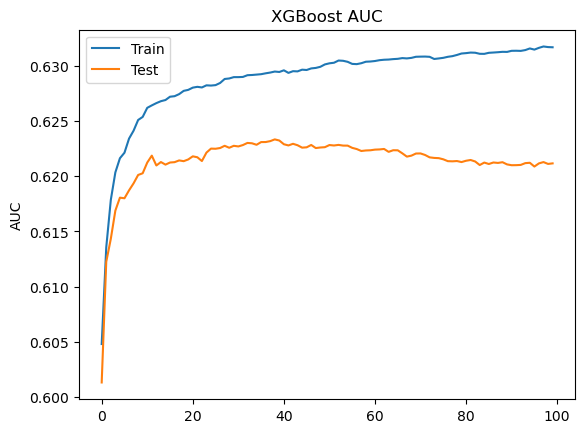

0.62117
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.042096039003674195, 'learning_rate': 0.07981903640978093, 'seed': 69, 'scale_pos_weight': 10.096424744276668} ['annual_inc', 'loan_amnt', 'fico_average', 'emp_length']


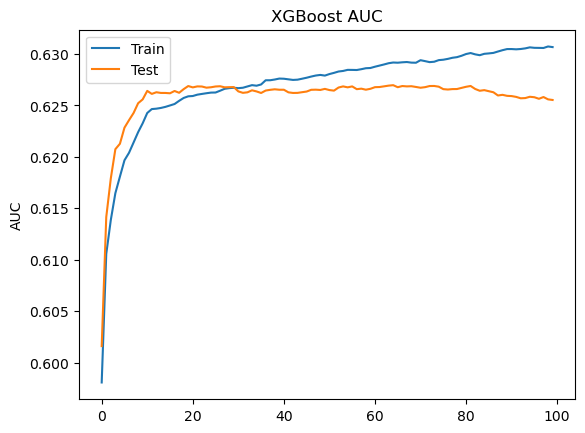

0.62553
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.042096039003674195, 'learning_rate': 0.07981903640978093, 'seed': 69, 'scale_pos_weight': 10.096424744276668} ['annual_inc', 'loan_amnt', 'fico_average', 'emp_length']


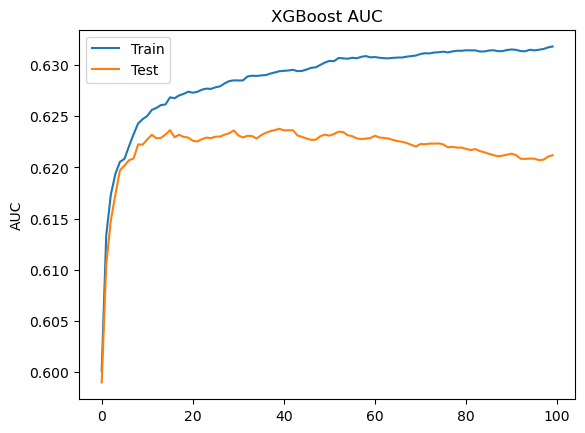

0.62119
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.042096039003674195, 'learning_rate': 0.07981903640978093, 'seed': 69, 'scale_pos_weight': 10.096424744276668} ['annual_inc', 'loan_amnt', 'fico_average', 'emp_length']


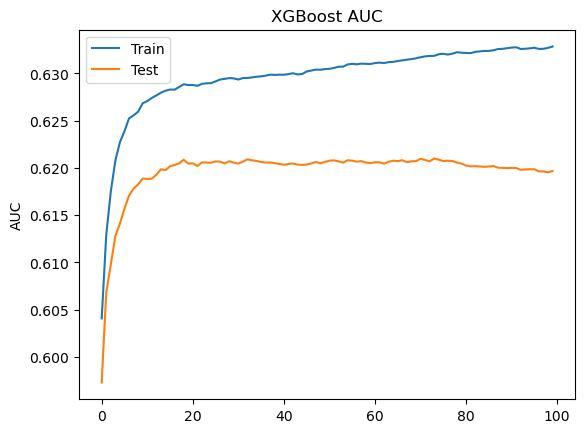

0.61968
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.042096039003674195, 'learning_rate': 0.07981903640978093, 'seed': 69, 'scale_pos_weight': 10.096640947704778} ['annual_inc', 'loan_amnt', 'fico_average', 'emp_length']


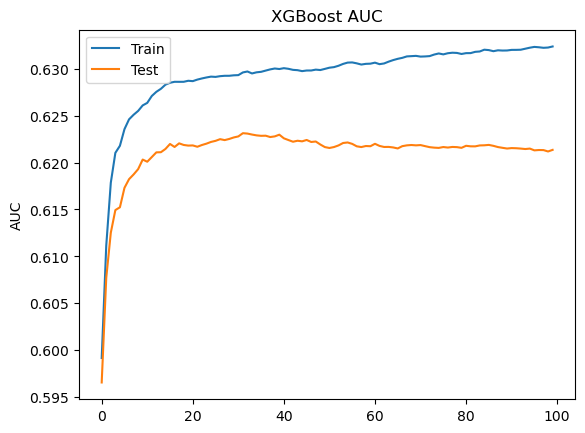

[I 2023-05-13 19:07:55,602] Trial 0 finished with value: 0.6217844889908617 and parameters: {'subsample': 0.042096039003674195, 'learning_rate': 0.07981903640978093, 'features': ('annual_inc', 'loan_amnt', 'fico_average', 'emp_length')}. Best is trial 0 with value: 0.6217844889908617.


0.62136


/Users/annakorytnik/opt/anaconda3/envs/kol_debug/lib/python3.8/site-packages/optuna/distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('annual_inc', 'loan_amnt') which is of type tuple.
  warnings.warn(message)
/Users/annakorytnik/opt/anaconda3/envs/kol_debug/lib/python3.8/site-packages/optuna/distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('annual_inc', 'loan_amnt', 'fico_average') which is of type tuple.
  warnings.warn(message)
/Users/annakorytnik/opt/anaconda3/envs/kol_debug/lib/python3.8/site-packages/optuna/distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('annual_inc', 'loan_amnt', 'fico_average', 'emp_length') which is of type tuple.
  warnings

{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.0020259041307232333, 'learning_rate': 0.041980621000886, 'seed': 69, 'scale_pos_weight': 10.096424744276668} ['annual_inc', 'loan_amnt', 'fico_average']


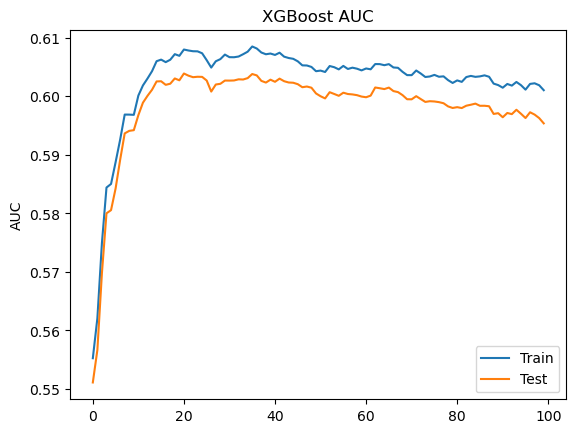

0.59538
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.0020259041307232333, 'learning_rate': 0.041980621000886, 'seed': 69, 'scale_pos_weight': 10.096424744276668} ['annual_inc', 'loan_amnt', 'fico_average']


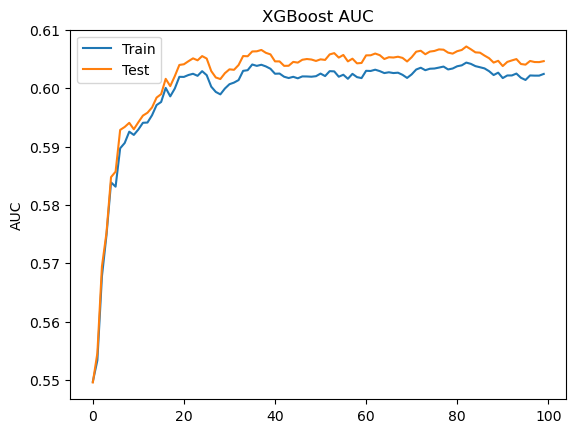

0.60466
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.0020259041307232333, 'learning_rate': 0.041980621000886, 'seed': 69, 'scale_pos_weight': 10.096424744276668} ['annual_inc', 'loan_amnt', 'fico_average']


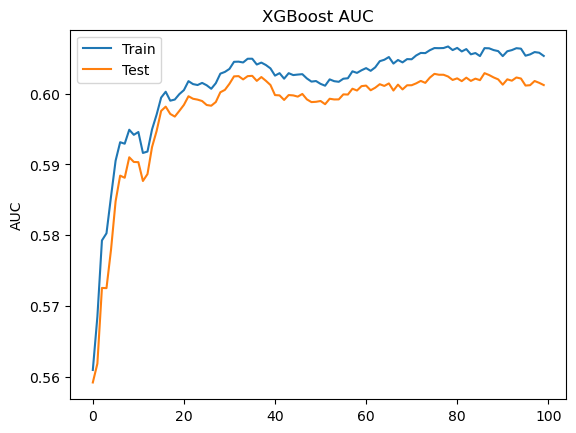

0.6012
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.0020259041307232333, 'learning_rate': 0.041980621000886, 'seed': 69, 'scale_pos_weight': 10.096424744276668} ['annual_inc', 'loan_amnt', 'fico_average']


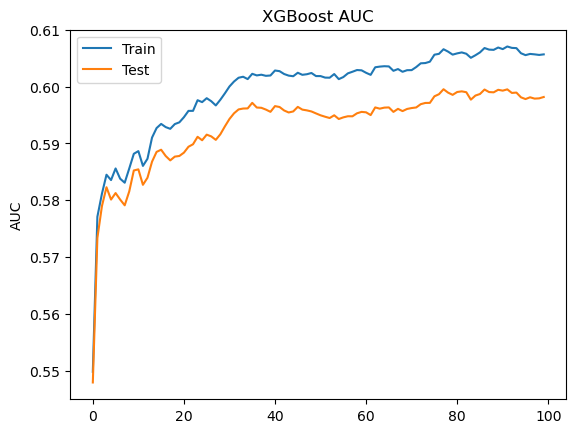

0.59819
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.0020259041307232333, 'learning_rate': 0.041980621000886, 'seed': 69, 'scale_pos_weight': 10.096640947704778} ['annual_inc', 'loan_amnt', 'fico_average']


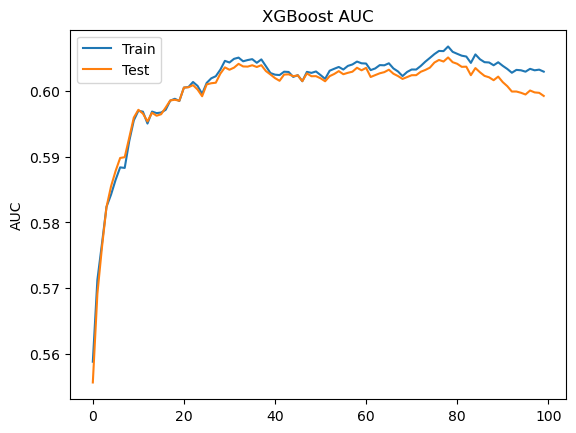

[I 2023-05-13 19:09:25,966] Trial 1 finished with value: 0.5997326346875514 and parameters: {'subsample': 0.0020259041307232333, 'learning_rate': 0.041980621000886, 'features': ('annual_inc', 'loan_amnt', 'fico_average')}. Best is trial 0 with value: 0.6217844889908617.


0.59924


/Users/annakorytnik/opt/anaconda3/envs/kol_debug/lib/python3.8/site-packages/optuna/distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('annual_inc', 'loan_amnt') which is of type tuple.
  warnings.warn(message)
/Users/annakorytnik/opt/anaconda3/envs/kol_debug/lib/python3.8/site-packages/optuna/distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('annual_inc', 'loan_amnt', 'fico_average') which is of type tuple.
  warnings.warn(message)
/Users/annakorytnik/opt/anaconda3/envs/kol_debug/lib/python3.8/site-packages/optuna/distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('annual_inc', 'loan_amnt', 'fico_average', 'emp_length') which is of type tuple.
  warnings

{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.2948222134786993, 'learning_rate': 0.044518451167813854, 'seed': 69, 'scale_pos_weight': 10.096424744276668} ['annual_inc', 'loan_amnt', 'fico_average']


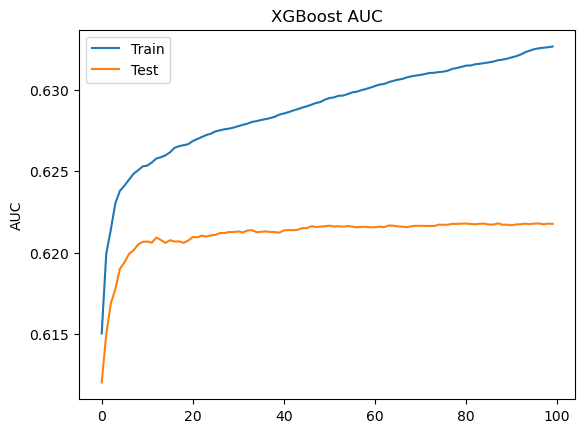

0.62177
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.2948222134786993, 'learning_rate': 0.044518451167813854, 'seed': 69, 'scale_pos_weight': 10.096424744276668} ['annual_inc', 'loan_amnt', 'fico_average']


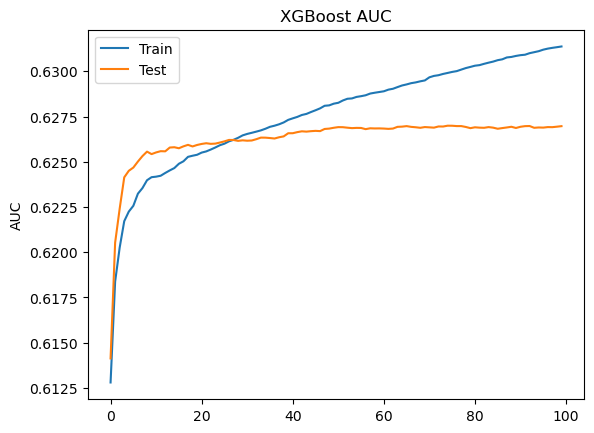

0.62697
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.2948222134786993, 'learning_rate': 0.044518451167813854, 'seed': 69, 'scale_pos_weight': 10.096424744276668} ['annual_inc', 'loan_amnt', 'fico_average']


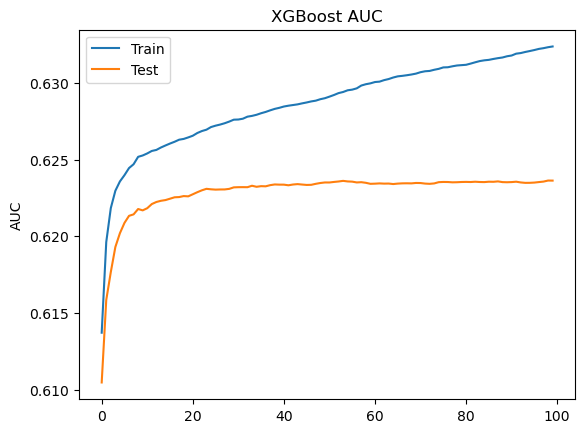

0.62363
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.2948222134786993, 'learning_rate': 0.044518451167813854, 'seed': 69, 'scale_pos_weight': 10.096424744276668} ['annual_inc', 'loan_amnt', 'fico_average']


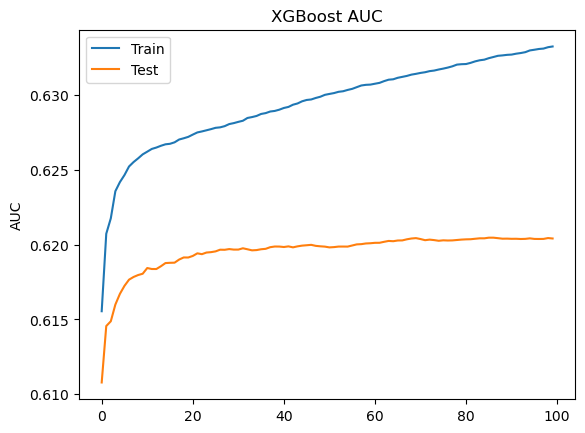

0.62041
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.2948222134786993, 'learning_rate': 0.044518451167813854, 'seed': 69, 'scale_pos_weight': 10.096640947704778} ['annual_inc', 'loan_amnt', 'fico_average']


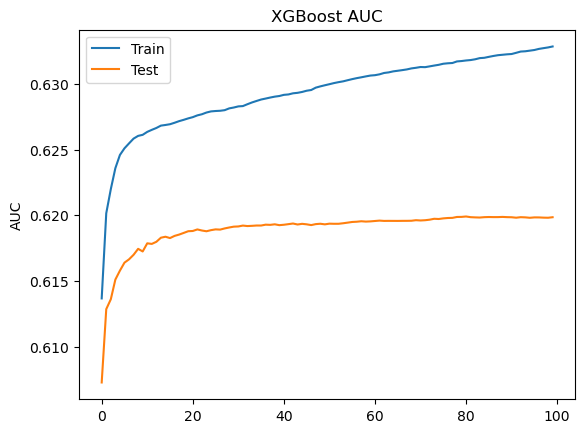

[I 2023-05-13 19:11:16,274] Trial 2 finished with value: 0.6225250357855987 and parameters: {'subsample': 0.2948222134786993, 'learning_rate': 0.044518451167813854, 'features': ('annual_inc', 'loan_amnt', 'fico_average')}. Best is trial 2 with value: 0.6225250357855987.


0.61985


/Users/annakorytnik/opt/anaconda3/envs/kol_debug/lib/python3.8/site-packages/optuna/distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('annual_inc', 'loan_amnt') which is of type tuple.
  warnings.warn(message)
/Users/annakorytnik/opt/anaconda3/envs/kol_debug/lib/python3.8/site-packages/optuna/distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('annual_inc', 'loan_amnt', 'fico_average') which is of type tuple.
  warnings.warn(message)
/Users/annakorytnik/opt/anaconda3/envs/kol_debug/lib/python3.8/site-packages/optuna/distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('annual_inc', 'loan_amnt', 'fico_average', 'emp_length') which is of type tuple.
  warnings

{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.10312371319826413, 'learning_rate': 0.12197941732889761, 'seed': 69, 'scale_pos_weight': 10.096424744276668} ['annual_inc', 'loan_amnt', 'fico_average']


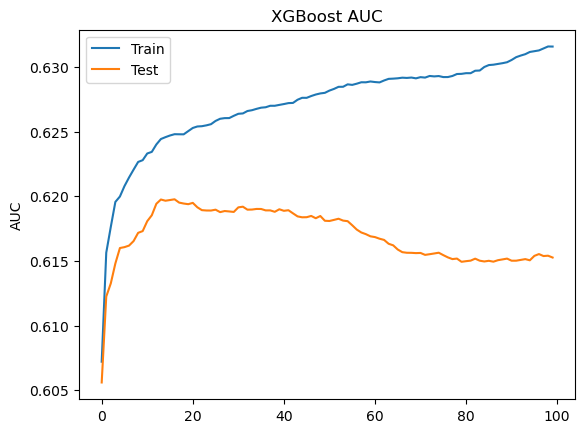

0.61526
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.10312371319826413, 'learning_rate': 0.12197941732889761, 'seed': 69, 'scale_pos_weight': 10.096424744276668} ['annual_inc', 'loan_amnt', 'fico_average']


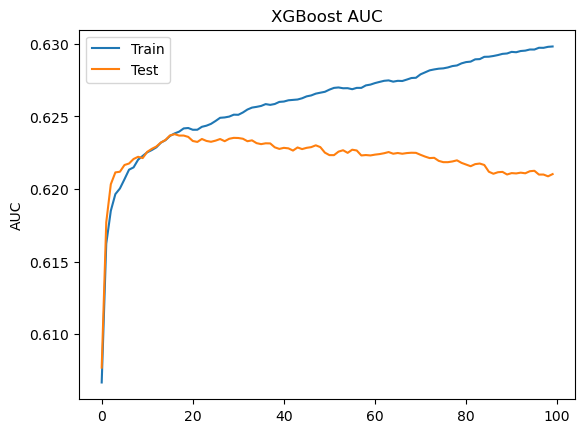

0.62103
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.10312371319826413, 'learning_rate': 0.12197941732889761, 'seed': 69, 'scale_pos_weight': 10.096424744276668} ['annual_inc', 'loan_amnt', 'fico_average']


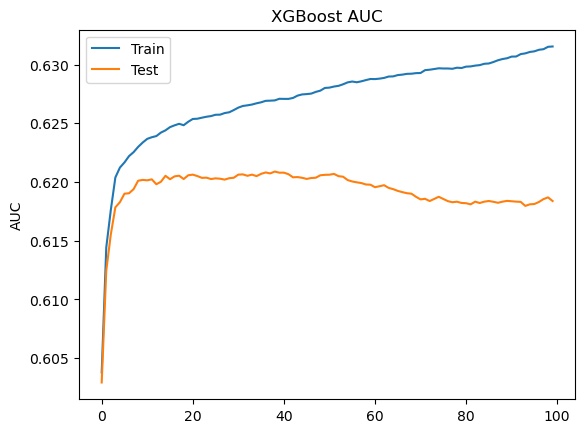

0.61838
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.10312371319826413, 'learning_rate': 0.12197941732889761, 'seed': 69, 'scale_pos_weight': 10.096424744276668} ['annual_inc', 'loan_amnt', 'fico_average']


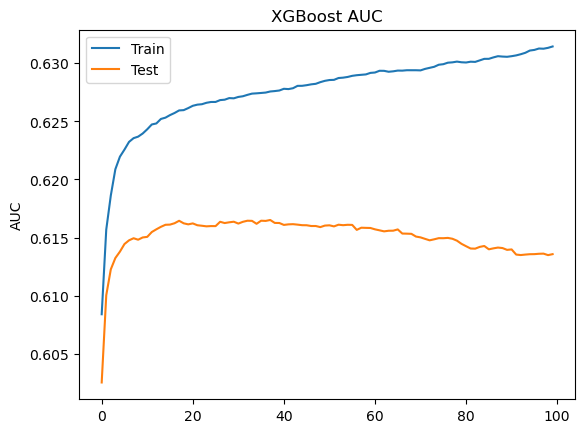

0.61357
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.10312371319826413, 'learning_rate': 0.12197941732889761, 'seed': 69, 'scale_pos_weight': 10.096640947704778} ['annual_inc', 'loan_amnt', 'fico_average']


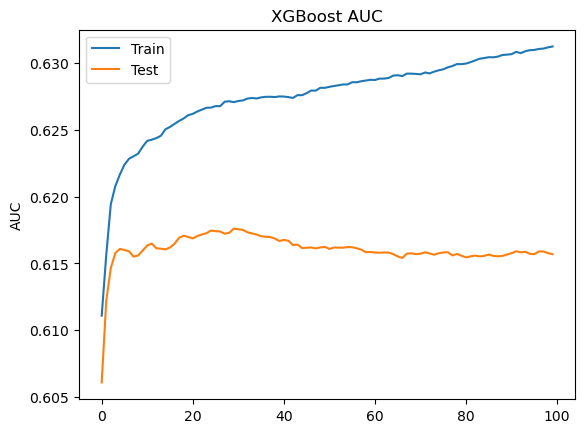

[I 2023-05-13 19:13:02,069] Trial 3 finished with value: 0.6167859698291103 and parameters: {'subsample': 0.10312371319826413, 'learning_rate': 0.12197941732889761, 'features': ('annual_inc', 'loan_amnt', 'fico_average')}. Best is trial 2 with value: 0.6225250357855987.


0.61568


/Users/annakorytnik/opt/anaconda3/envs/kol_debug/lib/python3.8/site-packages/optuna/distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('annual_inc', 'loan_amnt') which is of type tuple.
  warnings.warn(message)
/Users/annakorytnik/opt/anaconda3/envs/kol_debug/lib/python3.8/site-packages/optuna/distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('annual_inc', 'loan_amnt', 'fico_average') which is of type tuple.
  warnings.warn(message)
/Users/annakorytnik/opt/anaconda3/envs/kol_debug/lib/python3.8/site-packages/optuna/distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('annual_inc', 'loan_amnt', 'fico_average', 'emp_length') which is of type tuple.
  warnings

{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.002012134778131314, 'learning_rate': 0.041168142630142464, 'seed': 69, 'scale_pos_weight': 10.096424744276668} ['annual_inc', 'loan_amnt']


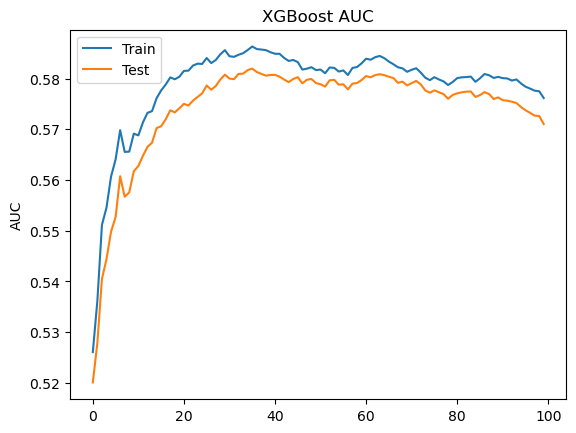

0.57105
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.002012134778131314, 'learning_rate': 0.041168142630142464, 'seed': 69, 'scale_pos_weight': 10.096424744276668} ['annual_inc', 'loan_amnt']


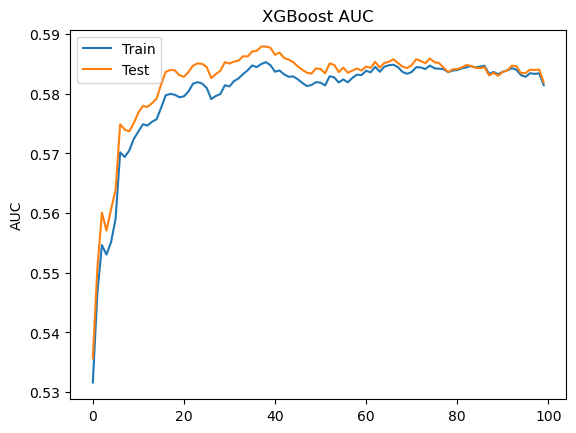

0.5819
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.002012134778131314, 'learning_rate': 0.041168142630142464, 'seed': 69, 'scale_pos_weight': 10.096424744276668} ['annual_inc', 'loan_amnt']


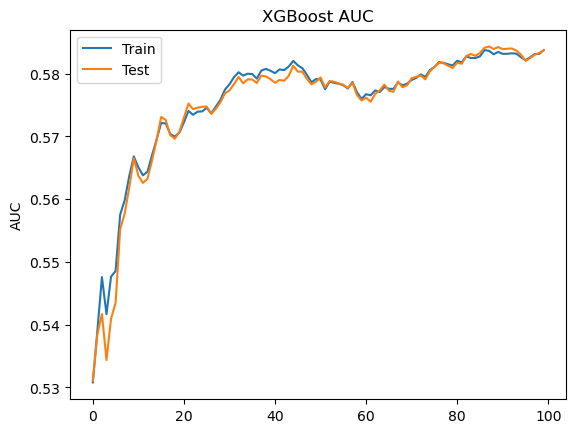

0.5837
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.002012134778131314, 'learning_rate': 0.041168142630142464, 'seed': 69, 'scale_pos_weight': 10.096424744276668} ['annual_inc', 'loan_amnt']


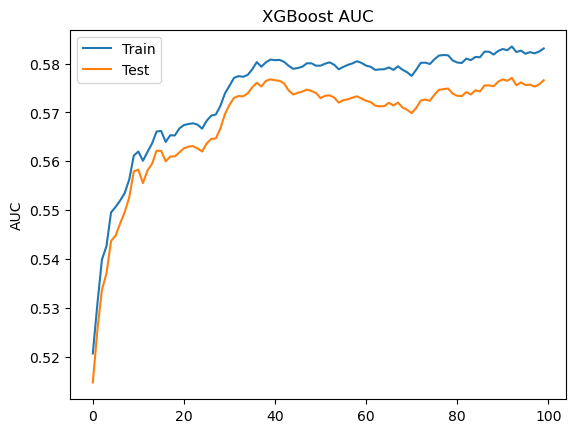

0.57658
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.002012134778131314, 'learning_rate': 0.041168142630142464, 'seed': 69, 'scale_pos_weight': 10.096640947704778} ['annual_inc', 'loan_amnt']


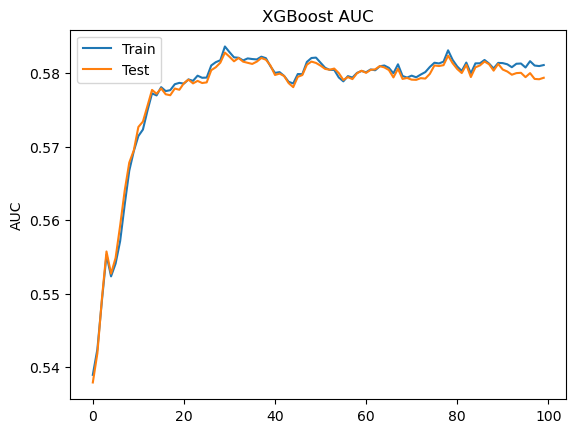

[I 2023-05-13 19:14:24,018] Trial 4 finished with value: 0.5785178113481901 and parameters: {'subsample': 0.002012134778131314, 'learning_rate': 0.041168142630142464, 'features': ('annual_inc', 'loan_amnt')}. Best is trial 2 with value: 0.6225250357855987.


0.57936


/Users/annakorytnik/opt/anaconda3/envs/kol_debug/lib/python3.8/site-packages/optuna/distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('annual_inc', 'loan_amnt') which is of type tuple.
  warnings.warn(message)
/Users/annakorytnik/opt/anaconda3/envs/kol_debug/lib/python3.8/site-packages/optuna/distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('annual_inc', 'loan_amnt', 'fico_average') which is of type tuple.
  warnings.warn(message)
/Users/annakorytnik/opt/anaconda3/envs/kol_debug/lib/python3.8/site-packages/optuna/distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('annual_inc', 'loan_amnt', 'fico_average', 'emp_length') which is of type tuple.
  warnings

{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.04739708245340465, 'learning_rate': 0.21120615776609283, 'seed': 69, 'scale_pos_weight': 10.096424744276668} ['annual_inc', 'loan_amnt']


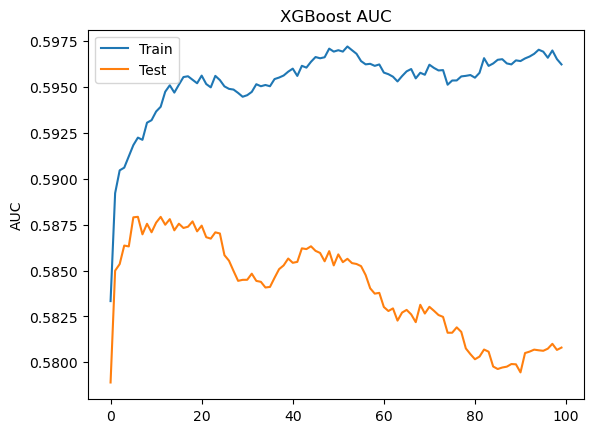

0.5808


In [10]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

In [ ]:
study.best_trials

[FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.5841330582073612], datetime_start=datetime.datetime(2023, 5, 13, 18, 34, 44, 410982), datetime_complete=datetime.datetime(2023, 5, 13, 18, 36, 35, 19502), params={'subsample': 0.6701497743342159, 'learning_rate': 0.18413715344103385}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'subsample': FloatDistribution(high=1.0, log=True, low=0.001, step=None), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None)}, trial_id=2, value=None)]

[FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.5706904511659537], datetime_start=datetime.datetime(2023, 5, 13, 18, 25, 38, 19301), datetime_complete=datetime.datetime(2023, 5, 13, 18, 27, 1, 321098), params={'subsample': 0.06435314059498777, 'learning_rate': 0.036202388856127116}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'subsample': FloatDistribution(high=1.0, log=True, low=0.001, step=None), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None)}, trial_id=2, value=None)]

[FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.5841330582073612], datetime_start=datetime.datetime(2023, 5, 13, 18, 34, 44, 410982), datetime_complete=datetime.datetime(2023, 5, 13, 18, 36, 35, 19502), params={'subsample': 0.6701497743342159, 'learning_rate': 0.18413715344103385}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'subsample': FloatDistribution(high=1.0, log=True, low=0.001, step=None), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None)}, trial_id=2, value=None)]